# 4:2 MENT — random uncoupled phase advances

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
import ment.train
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 4
nmeas = 9
nbins = 50
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed, noise=0.25)
x_true = dist.sample(1_000_000)

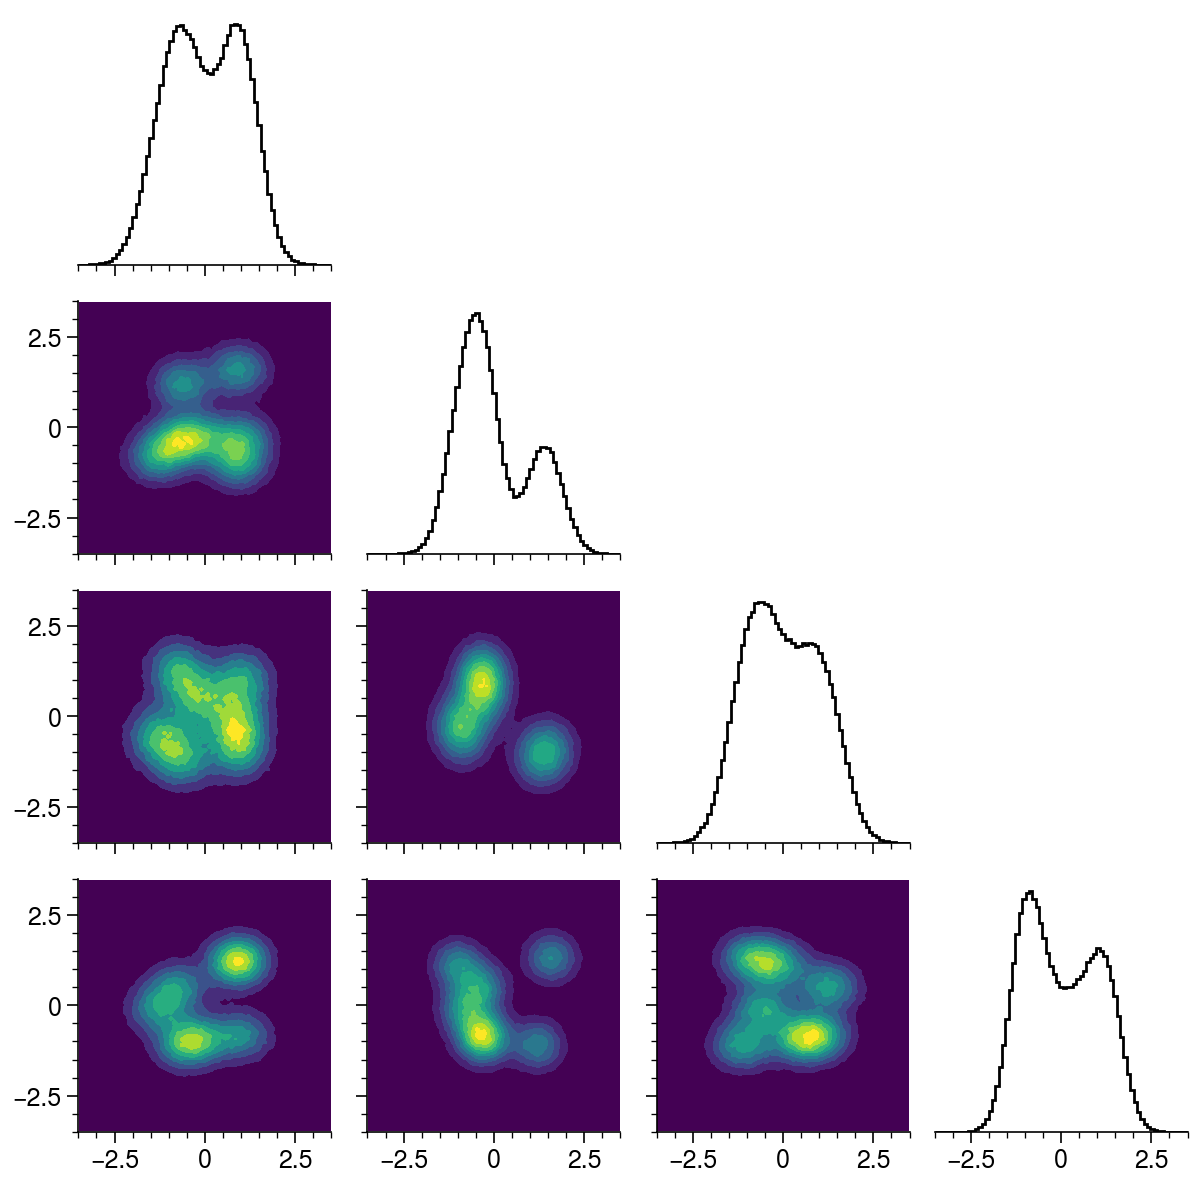

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot(x_true, limits=limits, bins=75, mask=False, kind="contourf")
plt.show()

## Data generation

In [6]:
# Create transforms (random phase advances)
rng = np.random.default_rng(seed)
phase_advances = rng.uniform(0.0, np.pi, size=(nmeas, 2))
transfer_matrices = []
for mux, muy in phase_advances:
    matrix = np.eye(ndim)
    matrix[0:2, 0:2] = ment.sim.rotation_matrix(mux)
    matrix[2:4, 2:4] = ment.sim.rotation_matrix(muy)
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create diagnostics (x-y histogram).
axis_proj = (0, 2)
bin_edges = len(axis_proj) * [np.linspace(-xmax, xmax, nbins + 1)]

projections = []
for transform in transforms:
    projection = ment.diag.HistogramND(axis=(0, 2), edges=bin_edges)
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

samp_grid_res = 32
samp_noise = 0.0
samp_grid_shape = ndim * [samp_grid_res]
samp_grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=samp_grid_limits,
    grid_shape=samp_grid_shape,
    noise=samp_noise,
)

integration_limits = [limits[axis] for axis in range(ndim) if axis not in axis_proj]
integration_limits = [[integration_limits]] * len(transforms)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=1_000_000,
    integration_limits=integration_limits,
    integration_size=(15**4),
    integration_batches=1,
    mode="sample",  # {"sample", "integrate"}
    verbose=2,
)

## Training

In [8]:
def plot_model(model):
    figs = []

    # Plot reconstructed vs. true distribution.
    x_pred = model.sample(1_000_000)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = model.projections
    projections_true = unravel(projections_true)

    projections_pred = ment.sim.simulate(x_pred, model.transforms, model.diagnostics)
    projections_pred = unravel(projections_pred)

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for ax, proj_true, proj_pred in zip(axs, projections_true, projections_pred):
        psv.plot_hist(
            proj_true,
            ax=ax,
            kind="contour",
            process_kws=dict(blur=0.5, scale="max"),
            colors="black",
            lw=0.9,
            levels=np.linspace(0.01, 1.0, 7),
        )
        psv.plot_hist(
            proj_pred,
            ax=ax,
            kind="contour",
            process_kws=dict(blur=0.5, scale="max"),
            colors="red",
            lw=0.9,
            levels=np.linspace(0.01, 1.0, 7),
        )
    figs.append(fig)

    return figs

non numeric history values being saved


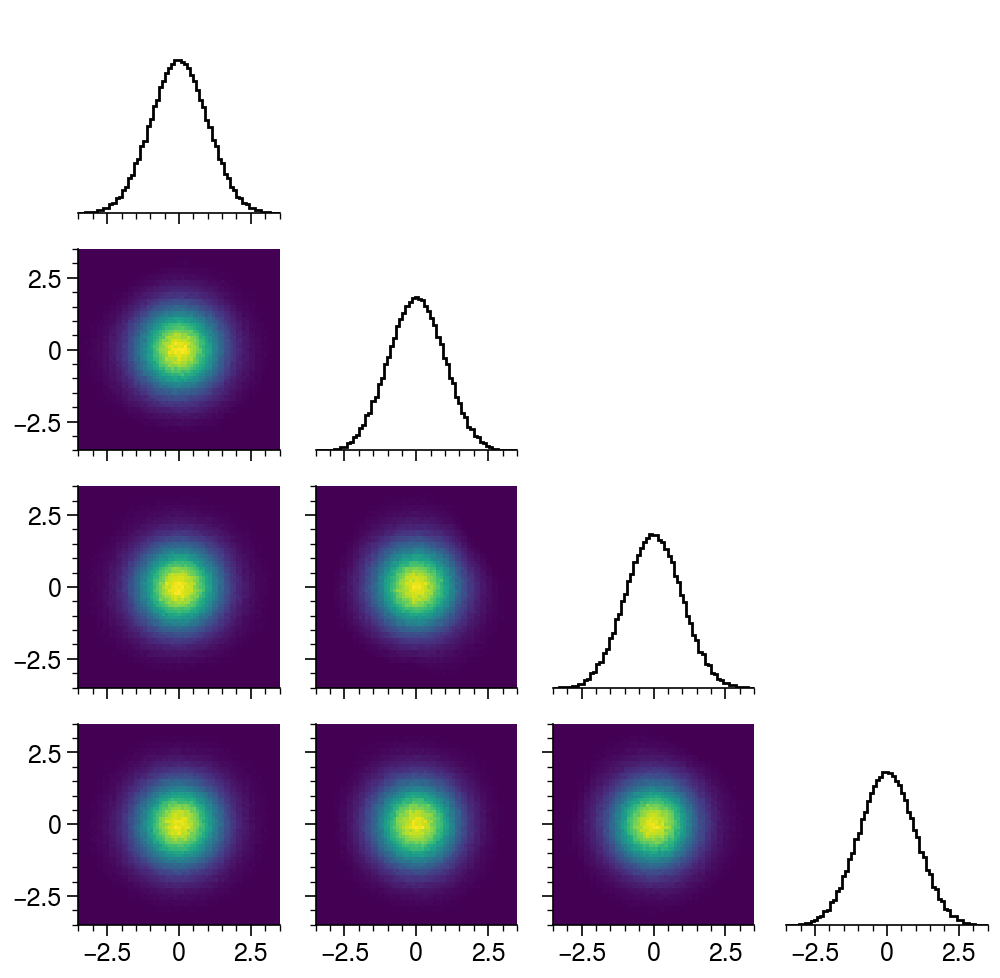

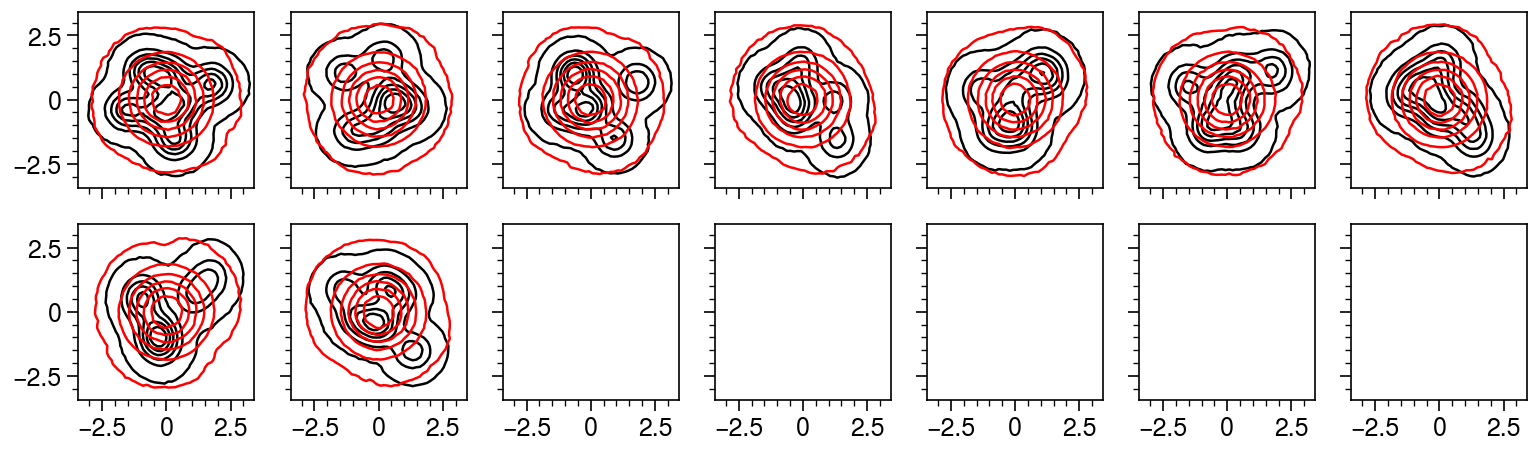

None
epoch = 1
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


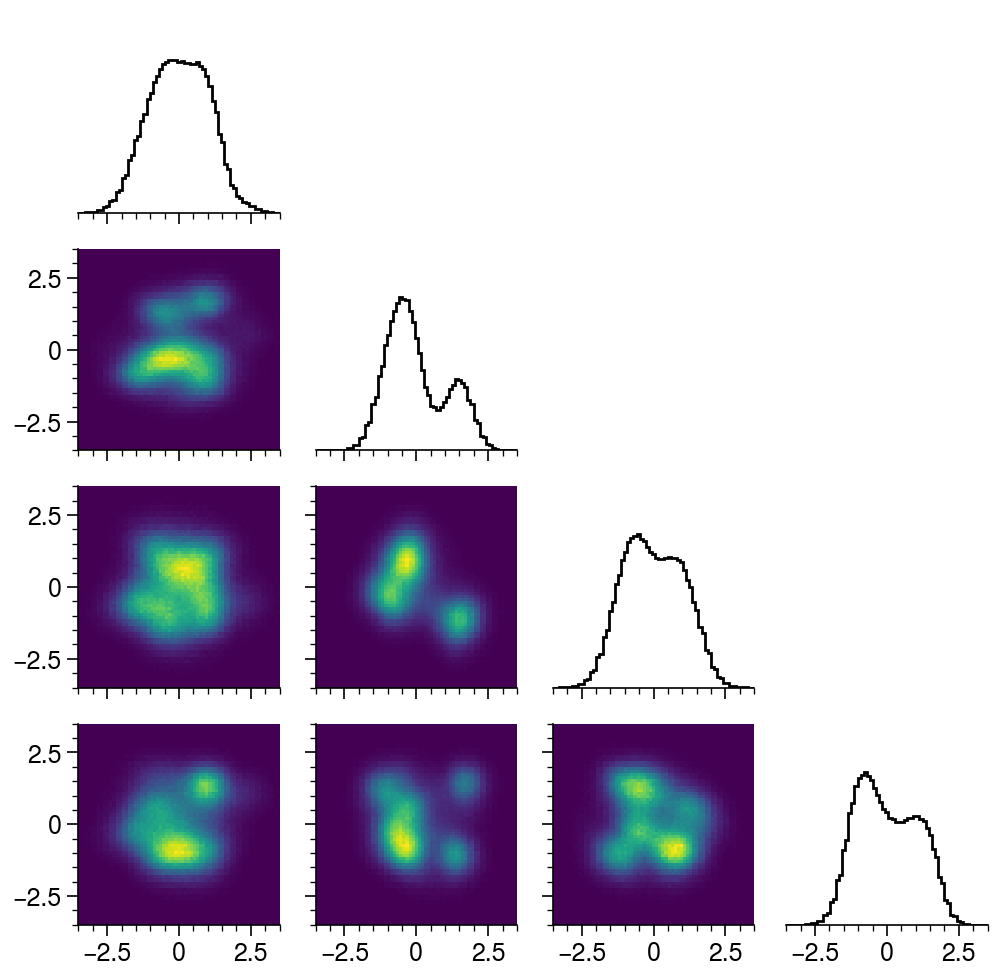

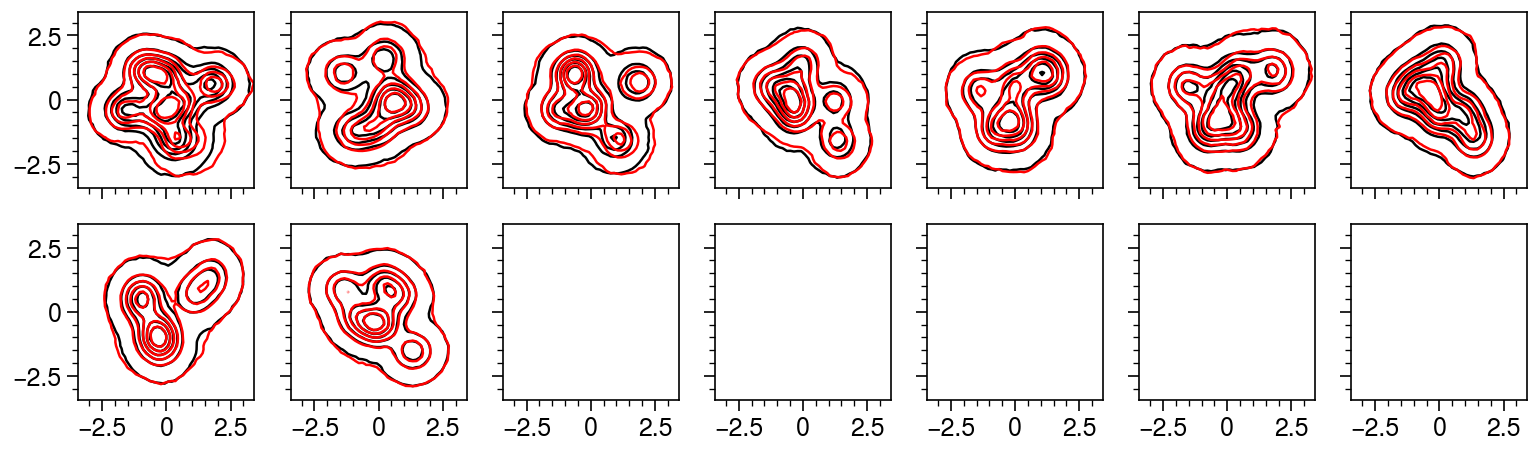

None
epoch = 2
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


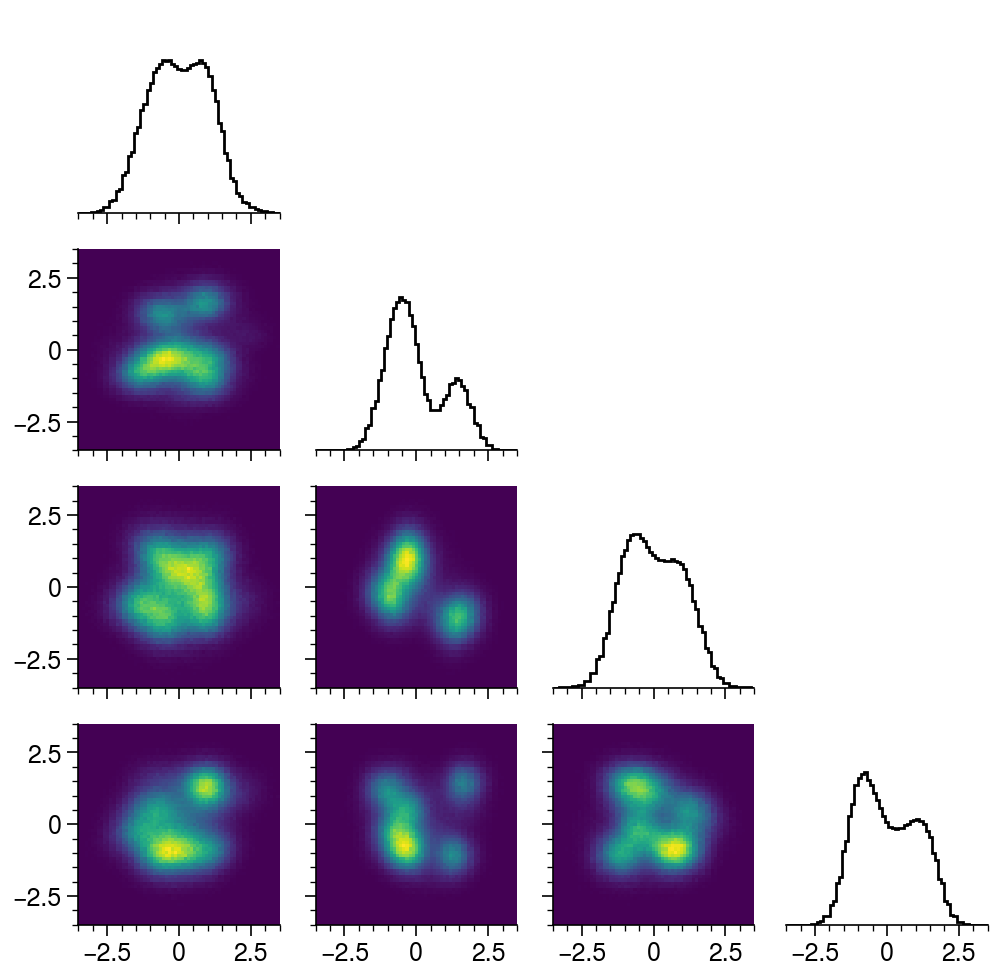

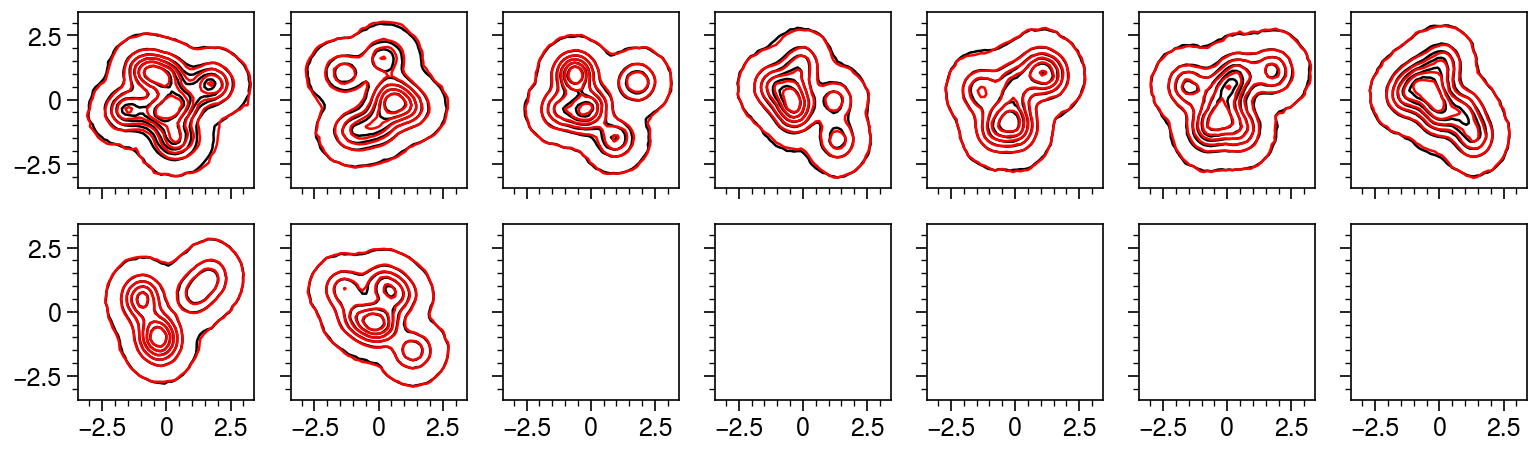

None
epoch = 3
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


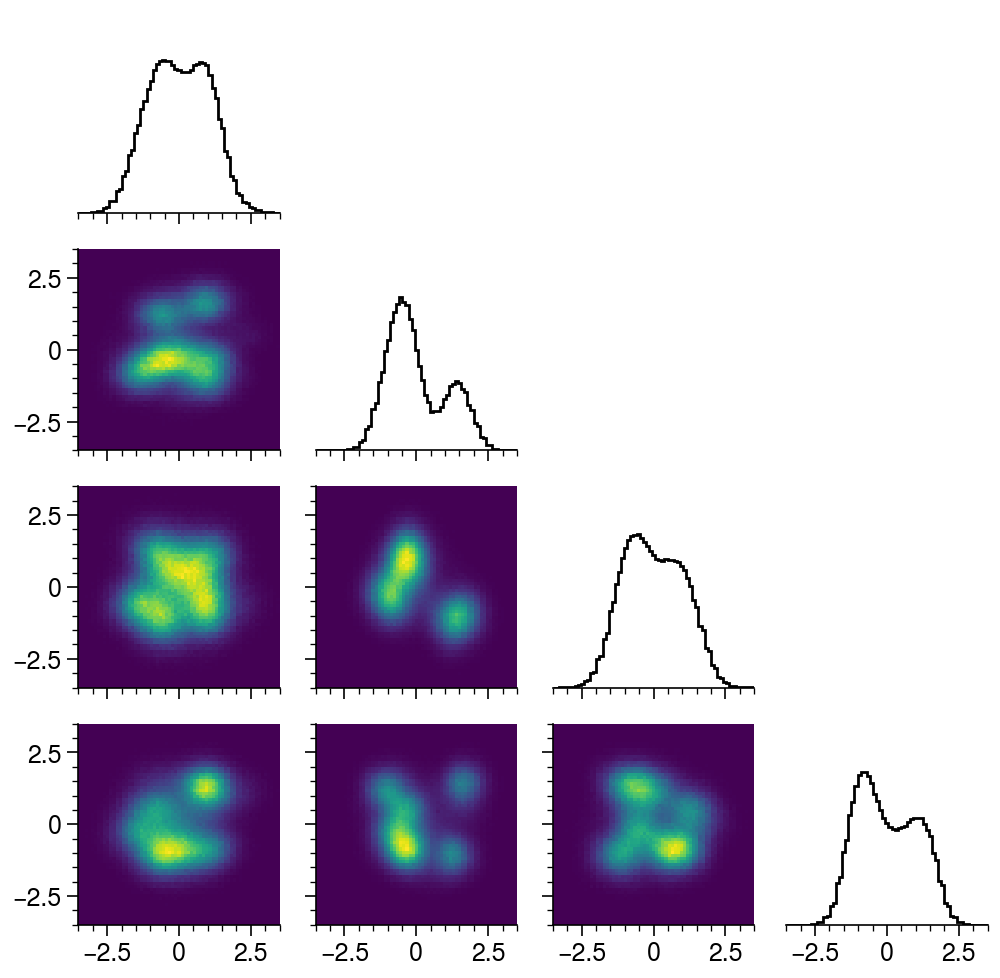

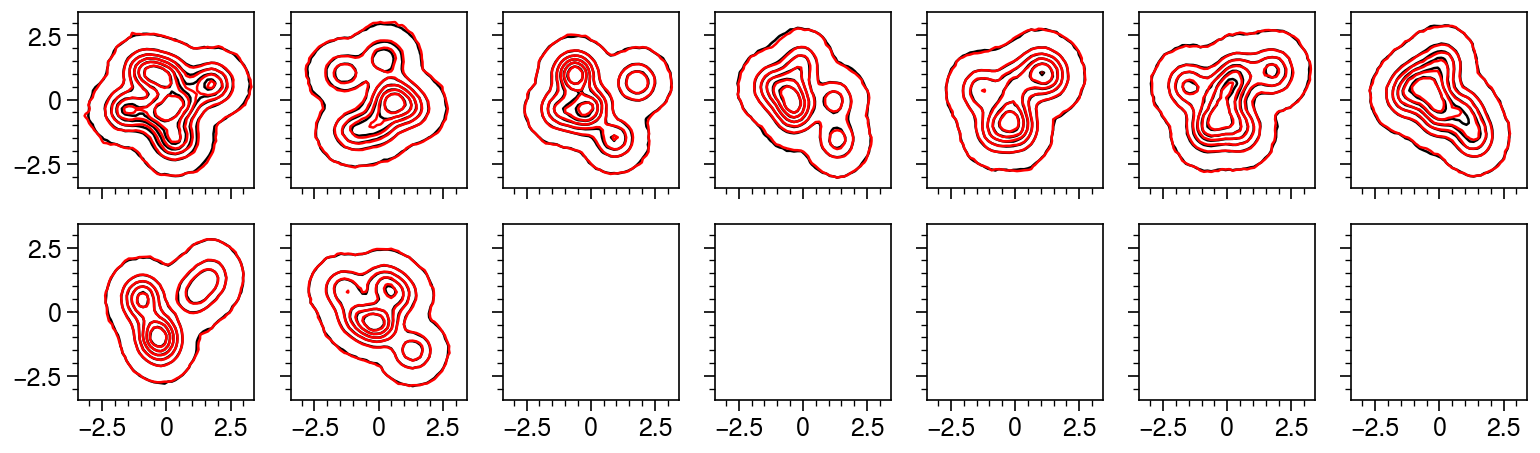

None


In [9]:
model.mode = "sample"

trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)